# Tracking Lorenz 63 using continuous-discrete Extended / Ensemble / Unscented Kalman filter

This notebook demonstrates tracking chaotic dynamics from the Lorenz 63 system from partial and noisy observations sampled at irregular time intervals.

We generate dynamics according to the following stochastic differential equation:
\begin{align*}
\frac{d^2 x}{d t^2} &= a(y-x) + \sigma w_x(t) \\
\frac{d^2 y}{d t^2} &= x(b-z) - y + \sigma w_y(t) \\
\frac{d^2 z}{d t^2} &= xy - cz + \sigma w_z(t),
\end{align*}
where $a=10, b=28, c=8/3$ give rise to chaotic behavior, and we choose $\sigma=0.1$ for light diffusion.

We numerically approximate random path solutions to this SDE using Heun's method (i.e. improved Euler), as implemented in [Diffrax](https://docs.kidger.site/diffrax/api/solvers/sde_solvers/).


We assume the observation model is
\begin{align*}
y(t) &= x(t) + r(t) \\
r(t) &\sim N(0,R),
\end{align*}
where we choose $R=I$. 

We collect measurements at irregular times sampled uniformly from a time domain $[0,40]$.

We approach the filtering problem using continuous-discrete Extended/Ensemble/Unscented Kalman Filters, and compare their performance. We see that the problem becomes more difficult when we have a slower sample rate and less knowledge of initial state distribution---in this setting, the Ensemble Kalman Filter shines and the Unscented Kalman Filter breaks at its first step (due to predicting a non-PSD state covariance).



## Setup

In [5]:
import sys
%matplotlib inline
sys.path.append("../../..")
sys.path.append("../..")

import dynamax

import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as jr
from jax import vmap
from jax import lax
from jaxtyping import Float, Array
from typing import Callable, NamedTuple, Tuple, Optional, Union
from jaxtyping import Array, Float, PyTree

from dynamax.parameters import ParameterProperties

# For pretty print of ndarrays
jnp.set_printoptions(formatter={"float_kind": "{:.2f}".format})

# import discrete-time filters
from dynamax.nonlinear_gaussian_ssm import ParamsNLGSSM, UKFHyperParams
from dynamax.nonlinear_gaussian_ssm import extended_kalman_smoother, unscented_kalman_smoother

# import continuous-discrete nonlinear Gaussian SSM code
# use custom src codebase
from utils.plotting_utils import *
from continuous_discrete_nonlinear_gaussian_ssm import ContDiscreteNonlinearGaussianSSM
from continuous_discrete_nonlinear_gaussian_ssm import cdnlgssm_filter
from continuous_discrete_nonlinear_gaussian_ssm import EnKFHyperParams, EKFHyperParams, UKFHyperParams

# set up drift function
from continuous_discrete_nonlinear_gaussian_ssm.models import (
    LearnableFunction,
    ConstantLearnableFunction,
    LinearLearnableFunction,
)


In [6]:
def plot_lorenz(time_grid, x_tr, x_obs, x_est=None, est_type=""):
    plt.figure()
    n_states = x_tr.shape[1]
    for i in range(n_states):
        plt.plot(time_grid, x_tr[:, i], color=f"C{i}", alpha=0.5, linewidth=4, label=f"True State {i}")

    if x_est is not None:
        for i in range(n_states):
            plt.plot(
                time_grid, x_est[:, i], "--", color=f"C{i}", linewidth=1.5, label=f"{est_type} Estimated State {i}"
            )

    n_obs = x_obs.shape[1]
    for i in range(n_obs):
        plt.plot(time_grid, x_obs[:, i], "ok", fillstyle="none", ms=1.5, label=f"Measurement {i}")

    plt.xlabel("Time $t$")
    # plt.ylabel("Pendulum angle $x_{1,k}$")
    # plt.xlim(0, 5)
    # plt.ylim(-3, 5)
    # plt.xticks(jnp.arange(0.5, 4.6, 0.5))
    # plt.yticks(jnp.arange(-3, 5.1, 1))
    # plt.gca().set_aspect(0.5)
    plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor="k")
    plt.show()

In [7]:
# Compute RMSE
def compute_rmse(y, y_est):
    return jnp.sqrt(jnp.sum((y - y_est) ** 2) / len(y))


# Compute RMSE of estimate and print comparison with
# standard deviation of measurement noise
def compute_and_print_rmse_comparison(y, y_est, R, est_type=""):
    rmse_est = compute_rmse(y, y_est)
    print(f'{f"The RMSE of the {est_type} estimate is":<40}: {rmse_est:.2f}')
    print(f'{"The std of measurement noise is":<40}: {jnp.sqrt(R):.2f}')

In [8]:
## Main settings
state_dim = 3
emission_dim = 1


class CustomDrift(LearnableFunction):
    params: Union[Float[Array, "state_dim"], ParameterProperties]

    def f(self, x, u=None, t=None):
        foo = jnp.array(
            [
                self.params[0] * (x[1] - x[0]),
                self.params[1] * x[0] - x[1] - x[0] * x[2],
                -self.params[2] * x[2] + x[0] * x[1],
            ]
        )
        return foo


learnable_drift = CustomDrift(params=jnp.array([10.0, 28.0, 8 / 3]))
learnable_emission = LinearLearnableFunction(params=jnp.array([[1.0, 0.0, 0.0]]))
learnable_diffusion_cov = ConstantLearnableFunction(params=jnp.eye(state_dim))
learnable_diffusion_coefficient = ConstantLearnableFunction(params=0.1 * jnp.eye(state_dim))
learnable_emission_cov = ConstantLearnableFunction(params=jnp.eye(emission_dim))

true_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)

## Fast sample rate and modest initial state covariance

Text(0.5, 1.0, 'Training Emissions')

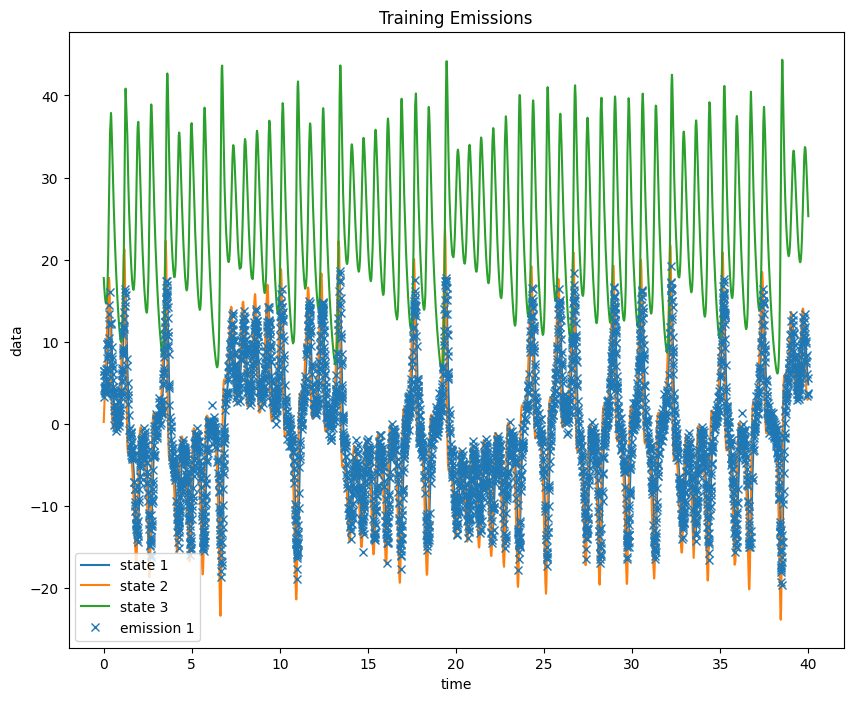

In [9]:
## Code
init_state_sd = 10
T = 40
num_timesteps = 4000
t_emissions = jnp.array(sorted(jr.uniform(jr.PRNGKey(0), (num_timesteps, 1), minval=0, maxval=T)))

# drop duplicates
t_emissions = jnp.unique(t_emissions)[:,None]
num_timesteps = len(t_emissions)

# set timesteps to be 400 timesteps at dt intervals
# t_emissions = jnp.arange(num_timesteps) * dt
# t_emissions = t_emissions.reshape(-1, 1)

key = jr.PRNGKey(0)
key, key_root = jr.split(key)
true_params, param_props = true_model.initialize(
    key,
    initial_mean=jnp.array([0.0, 0.0, 0.0]),
    initial_cov=jnp.eye(state_dim) * (init_state_sd**2),  # want to initialize at ~ initial mean
    dynamics_drift=learnable_drift,
    dynamics_diffusion_coefficient=learnable_diffusion_coefficient,
    dynamics_diffusion_cov=learnable_diffusion_cov,
    dynamics_approx_order=1.0,
    emission_function=learnable_emission,
    emission_cov=learnable_emission_cov,
)

key, key_root = jr.split(key)
true_states, emissions = true_model.sample(true_params, key, num_timesteps, t_emissions)

# Plot the true states and emissions
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t_emissions, true_states[:, 0], color="C0", label="state 1")
ax.plot(t_emissions, true_states[:, 1], color="C1", label="state 2")
ax.plot(t_emissions, true_states[:, 2], color="C2", label="state 3")
ax.plot(t_emissions, emissions[:, 0], "x", color="C0", label="emission 1")
ax.legend()
ax.set_ylabel("data")
ax.set_xlabel("time")
ax.set_title("Training Emissions")

### Extended Kalman Filter

The RMSE of the EKF estimate is         : 0.95
The std of measurement noise is         : 1.00


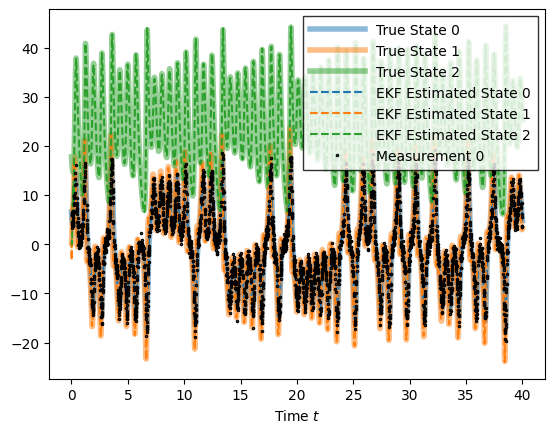

In [10]:
ekf_filtered = cdnlgssm_filter(true_params, emissions, EKFHyperParams(), t_emissions)
compute_and_print_rmse_comparison(true_states[:, -1], ekf_filtered.filtered_means[:, -1], 1, "EKF")
plot_lorenz(t_emissions, true_states, emissions, x_est=ekf_filtered.filtered_means, est_type="EKF")

### Ensemble Kalman Filter

The RMSE of the EnKF estimate is        : 0.91
The std of measurement noise is         : 1.00


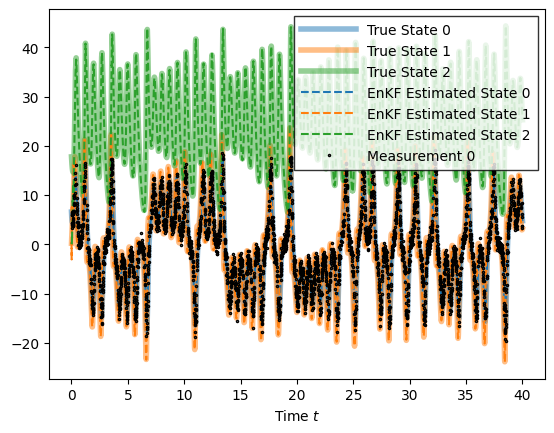

In [11]:
enkf_filtered = cdnlgssm_filter(true_params, emissions, EnKFHyperParams(), t_emissions)
compute_and_print_rmse_comparison(true_states[:, -1], enkf_filtered.filtered_means[:, -1], 1, "EnKF")
plot_lorenz(t_emissions, true_states, emissions, x_est=enkf_filtered.filtered_means, est_type="EnKF")

### Unscented Kalman Filter


The RMSE of the UKF estimate is         : 0.93
The std of measurement noise is         : 1.00


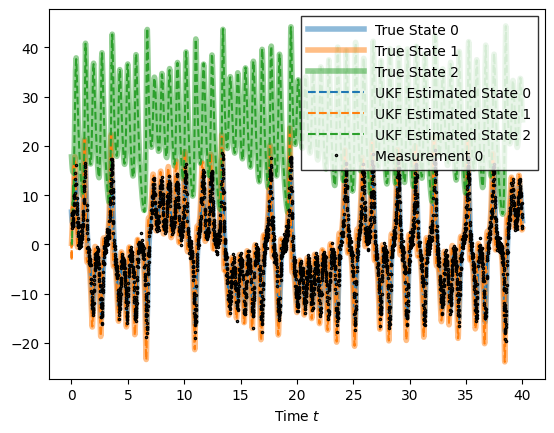

In [12]:
ukf_filtered = cdnlgssm_filter(true_params, emissions, UKFHyperParams(), t_emissions)
compute_and_print_rmse_comparison(true_states[:, -1], ukf_filtered.filtered_means[:, -1], 1, "UKF")
plot_lorenz(t_emissions, true_states, emissions, x_est=ukf_filtered.filtered_means, est_type="UKF")

## Slow sample rate and larger initial state covariance

Text(0.5, 1.0, 'Training Emissions')

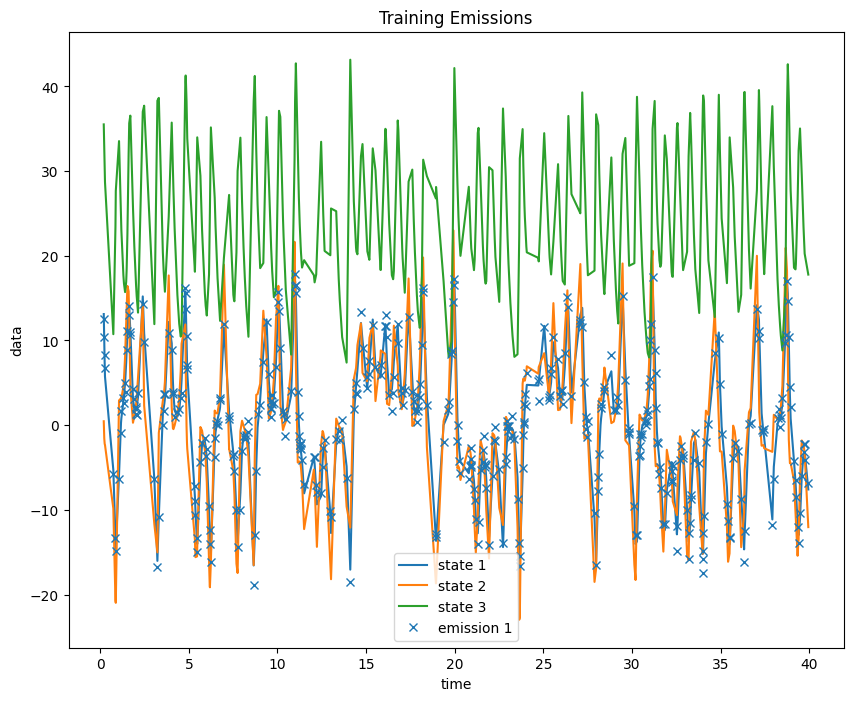

In [13]:
## Code

init_state_sd = 20
T = 40
num_timesteps = 400
t_emissions = jnp.array(sorted(jr.uniform(jr.PRNGKey(0), (num_timesteps, 1), minval=0, maxval=T)))

# drop duplicates
t_emissions = jnp.unique(t_emissions)
num_timesteps = len(t_emissions)
t_emissions = jnp.unique(t_emissions)[:, None]

# set timesteps to be 400 timesteps at dt intervals
# t_emissions = jnp.arange(num_timesteps) * dt
# t_emissions = t_emissions.reshape(-1, 1)

key = jr.PRNGKey(0)
key, key_root = jr.split(key)
true_params, param_props = true_model.initialize(
    key,
    initial_mean=jnp.array([0.0, 0.0, 0.0]),
    initial_cov=jnp.eye(state_dim) * (init_state_sd**2),  # want to initialize at ~ initial mean
    dynamics_drift=learnable_drift,
    dynamics_diffusion_coefficient=learnable_diffusion_coefficient,
    dynamics_diffusion_cov=learnable_diffusion_cov,
    dynamics_approx_order=1.0,
    emission_function=learnable_emission,
    emission_cov=learnable_emission_cov,
)

key, key_root = jr.split(key)
true_states, emissions = true_model.sample(true_params, key, num_timesteps, t_emissions)

# Plot the true states and emissions
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t_emissions, true_states[:, 0], color="C0", label="state 1")
ax.plot(t_emissions, true_states[:, 1], color="C1", label="state 2")
ax.plot(t_emissions, true_states[:, 2], color="C2", label="state 3")
ax.plot(t_emissions, emissions[:, 0], "x", color="C0", label="emission 1")
ax.legend()
ax.set_ylabel("data")
ax.set_xlabel("time")
ax.set_title("Training Emissions")

### Extended Kalman Filter

The RMSE of the EKF estimate is         : 11.04
The std of measurement noise is         : 1.00


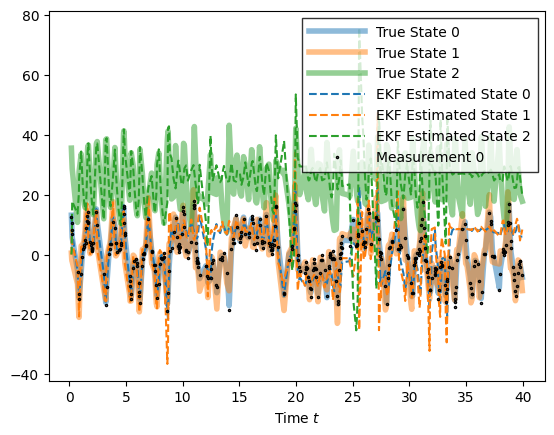

In [14]:
ekf_filtered = cdnlgssm_filter(true_params, emissions, EKFHyperParams(), t_emissions)
compute_and_print_rmse_comparison(true_states[:, -1], ekf_filtered.filtered_means[:, -1], 1, "EKF")
plot_lorenz(t_emissions, true_states, emissions, x_est=ekf_filtered.filtered_means, est_type="EKF")

### Ensemble Kalman Filter

The RMSE of the EnKF estimate is        : 2.99
The std of measurement noise is         : 1.00


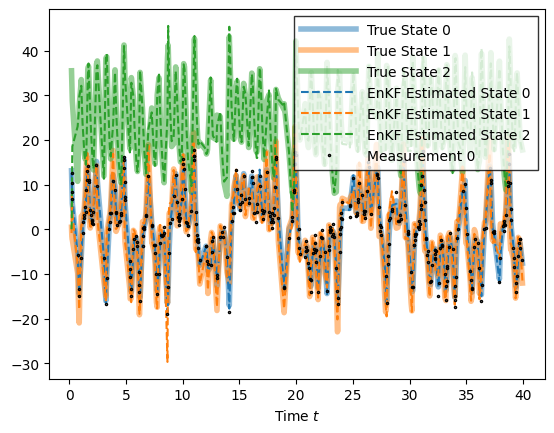

In [15]:
enkf_filtered = cdnlgssm_filter(true_params, emissions, EnKFHyperParams(), t_emissions)
compute_and_print_rmse_comparison(true_states[:, -1], enkf_filtered.filtered_means[:, -1], 1, "EnKF")
plot_lorenz(t_emissions, true_states, emissions, x_est=enkf_filtered.filtered_means, est_type="EnKF")

### Unscented Kalman Filter


The RMSE of the UKF estimate is         : nan
The std of measurement noise is         : 1.00


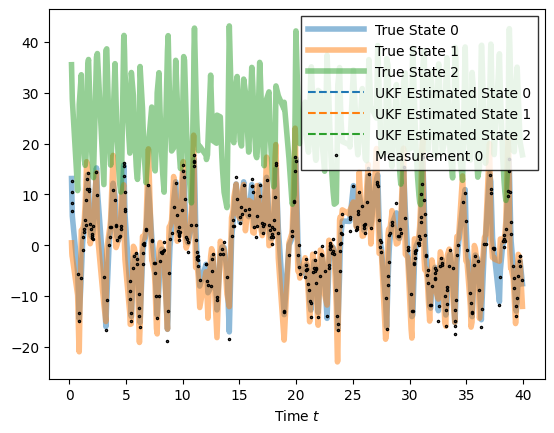

In [16]:
ukf_filtered = cdnlgssm_filter(true_params, emissions, UKFHyperParams(), t_emissions)
compute_and_print_rmse_comparison(true_states[:, -1], ukf_filtered.filtered_means[:, -1], 1, "UKF")
plot_lorenz(t_emissions, true_states, emissions, x_est=ukf_filtered.filtered_means, est_type="UKF")